### Importation of librairies:

In [225]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.stats import gaussian_kde
import seaborn as sns
%matplotlib widget

from collections import Counter
import cv2  # For image processing
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from tensorflow.keras.utils import to_categorical  # For one-hot encoding labels
import random




### Loading the Data:


In [226]:
# Path to the CSV files
bbox_list = r"Data\daataset3\BBox_List_2017.csv"
data_entry = r"Data\daataset3\Data_Entry_2017.csv"

# Loading the CSV files
bbox_list = pd.read_csv(bbox_list)
data_entry = pd.read_csv(data_entry)

# Displaying the first few rows of each dataframe
print("Data_Entry_2017.csv:")
print(data_entry.head())

print("\nBBox_List_2017.csv:")
print(bbox_list.head())

Data_Entry_2017.csv:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143

### Data Exploration and Cleaning:


In [227]:
# Checking for missing values in both dataframes
print("Missing values in Data_Entry_2017.csv:")
print(data_entry.isnull().sum())

print("\nMissing values in BBox_List_2017.csv:")
print(bbox_list.isnull().sum())

# Checking the shape of the dataframes
print("\nShape of Data_Entry_2017.csv:", data_entry.shape)
print("Shape of BBox_List_2017.csv:", bbox_list.shape)

# Checking unique values in the 'Finding Labels' column
print("\nUnique findings in Data_Entry_2017.csv:")
print(data_entry['Finding Labels'].unique())

Missing values in Data_Entry_2017.csv:
Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
dtype: int64

Missing values in BBox_List_2017.csv:
Image Index        0
Finding Label      0
Bbox [x            0
y                  0
w                  0
h]                 0
Unnamed: 6       984
Unnamed: 7       984
Unnamed: 8       984
dtype: int64

Shape of Data_Entry_2017.csv: (112120, 12)
Shape of BBox_List_2017.csv: (984, 9)

Unique findings in Data_Entry_2017.csv:
['Cardiomegaly' 'Cardiomegaly|Emphysema' 'Cardiomegaly|Effusion'
 'No Finding' 'Hernia' 'Hernia|Infiltration' 'Mass|Nodule' 'Inf

### Merging the Data:


In [228]:
# Merging the two dataframes on 'Image Index'
merged_data = pd.merge(data_entry, bbox_list, on='Image Index', how='inner')

# Displaying the first few rows of the merged dataframe
print("Merged Data:")
print(merged_data.head())

# Checking for missing values in the merged dataframe
print("\nMissing values in merged data:")
print(merged_data.isnull().sum())

Merged Data:
        Image Index                      Finding Labels  Follow-up #  \
0  00000032_037.png     Cardiomegaly|Edema|Infiltration           37   
1  00000072_000.png                         Atelectasis            0   
2  00000147_001.png                         Atelectasis            1   
3  00000149_006.png                         Atelectasis            6   
4  00000150_002.png  Atelectasis|Infiltration|Pneumonia            2   

   Patient ID  Patient Age Patient Gender View Position  OriginalImage[Width  \
0          32           55              F            AP                 2500   
1          72           67              F            PA                 2450   
2         147           66              F            PA                 2742   
3         149           71              M            AP                 2500   
4         150           55              F            AP                 3056   

   Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11 Finding Label

### Exploratory Data Analysis:

##### distributions of the variables:

       Follow-up #    Patient ID  Patient Age  OriginalImage[Width  \
count   984.000000    984.000000   984.000000           984.000000   
mean     13.746951  16424.805894    48.546748          2693.203252   
std      20.151208   8235.918529    19.780326           354.184193   
min       0.000000     32.000000     2.000000          1456.000000   
25%       2.000000  11098.750000    36.000000          2500.000000   
50%       6.000000  16596.500000    51.000000          2714.000000   
75%      17.000000  22215.000000    60.000000          2992.000000   
max     168.000000  30674.000000   412.000000          3056.000000   

           Height]  OriginalImagePixelSpacing[x          y]  Unnamed: 11  \
count   984.000000                   984.000000  984.000000          0.0   
mean   2511.930894                     0.153469    0.153469          NaN   
std     389.055550                     0.016928    0.016928          NaN   
min    1555.000000                     0.115000    0.115000      

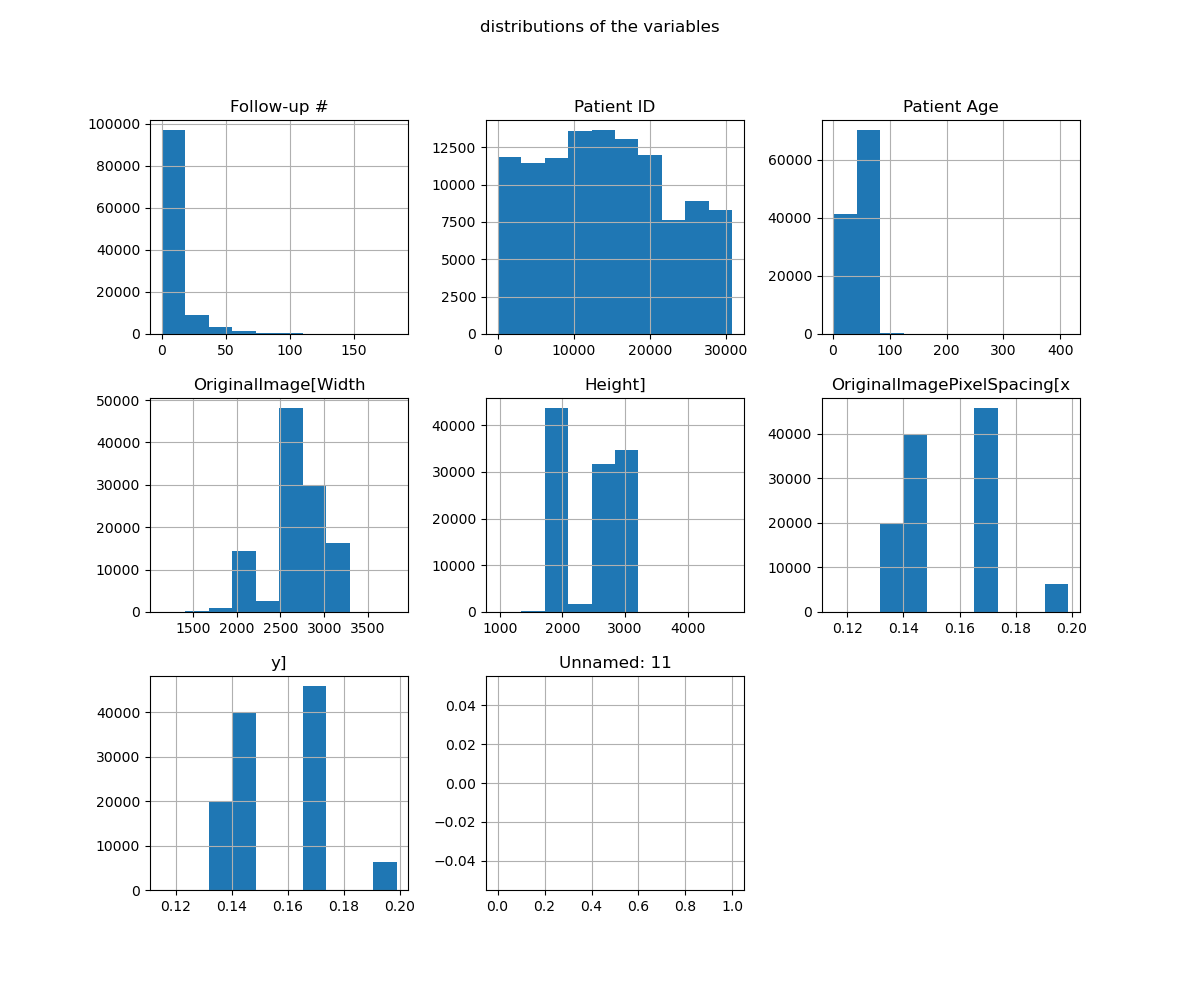

In [229]:
# Statistiques descriptives
print(merged_data.describe())

# Visualisation des distributions des variables
data_entry.hist(figsize=(12, 10))
plt.suptitle('distributions of the variables')
plt.show()

##### The distributions of the variables reveal several key insights:

 The "Follow-up #" distribution peaks around a specific value and then declines rapidly, indicating that higher values are less frequent. 
 
 The "Patient Age" distribution is concentrated around a certain age range, with a sharp decline for older ages, suggesting a predominantly young or middle-aged population. 
 
 The "Patient ID" distribution is fairly uniform, showing no particular bias in patient selection. 
 
 The "OriginalImage[Weight]" distribution is centered around certain values but has a long tail toward higher weights, indicating standard image weights with some significant outliers.
 
 Additionally, the "OriginalImagePixelSpacing[x]" and "OriginalImagePixelSpacing[y]" distributions are identical, suggesting a strong correlation (likely 1), which justifies removing one of the two columns.
 
 Finally, there is a variable that is entirely empty (all null values), and it should also be removed to clean the dataset.

##### Distribution of Findings:

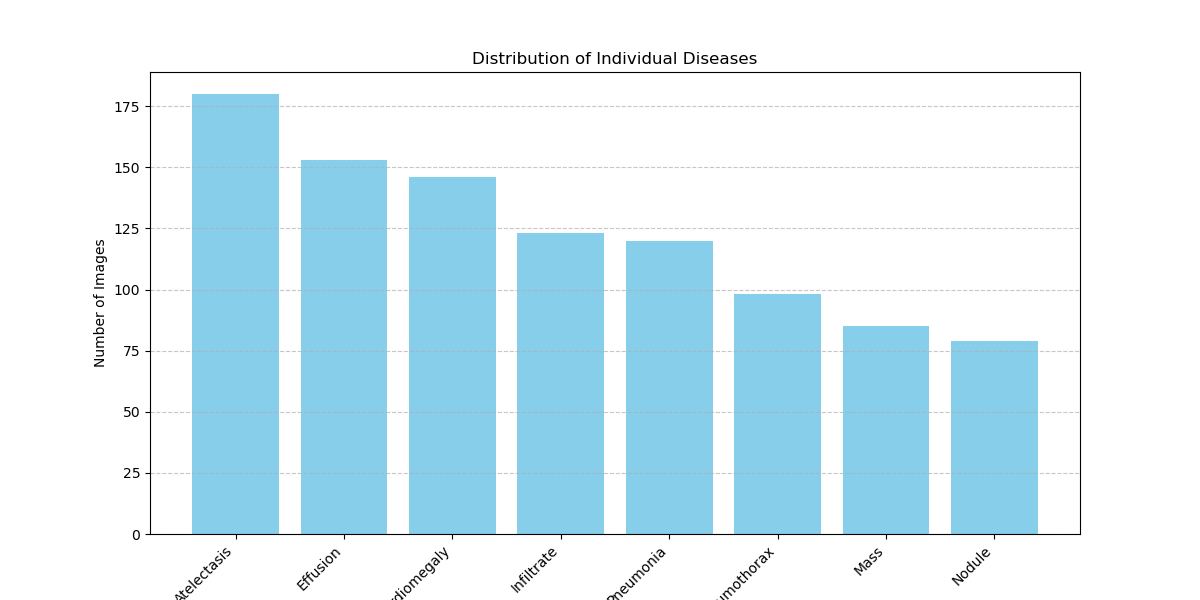

In [230]:
# Separate multiple labels and count individual occurrences
all_labels = []
for labels in bbox_list['Finding Label']:
    all_labels.extend(labels.split('|'))  # Separate combined labels

# Count the occurrences of each disease
label_counts_individual = Counter(all_labels)

# Sort diseases by frequency
sorted_labels = sorted(label_counts_individual.items(), key=lambda x: x[1], reverse=True)
labels, counts = zip(*sorted_labels)

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Diseases")
plt.ylabel("Number of Images")
plt.title("Distribution of Individual Diseases")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


##### Age and Gender Distribution:

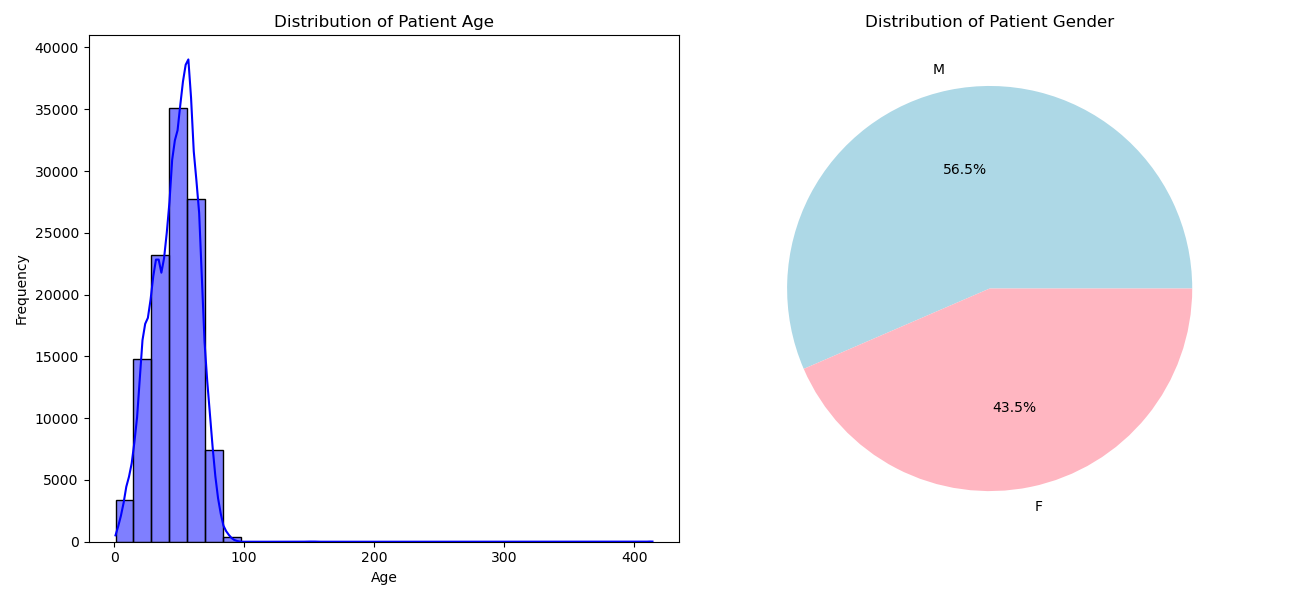

In [231]:


# Créer une figure explicite
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

# Tracer la distribution de l'âge des patients
sns.histplot(data_entry['Patient Age'], bins=30, kde=True, color='blue', ax=ax[0])
ax[0].set_title('Distribution of Patient Age')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Frequency')

# Tracer la distribution du genre des patients
gender_counts = data_entry['Patient Gender'].value_counts()
ax[1].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightpink'])
ax[1].set_title('Distribution of Patient Gender')

plt.tight_layout()
plt.show()
#plt.close()

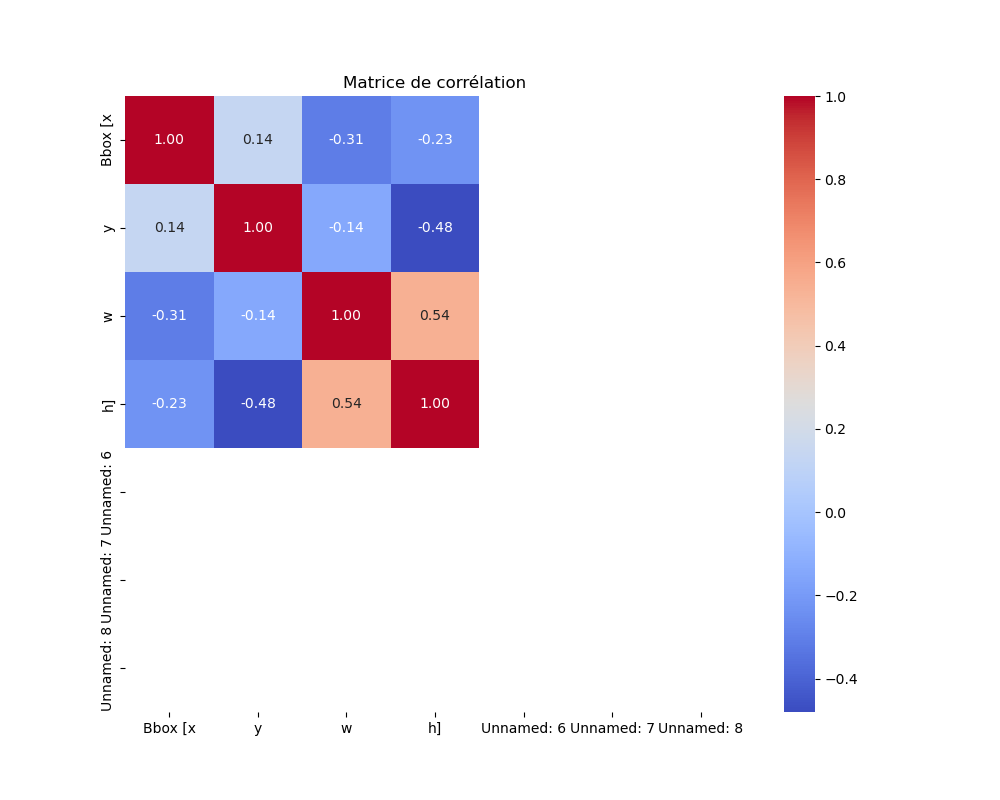

In [232]:
# Sélectionner uniquement les colonnes numériques
numeric_df = bbox_list.select_dtypes(include=[float, int])

# Heatmap des corrélations pour les colonnes numériques
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation')
plt.show()

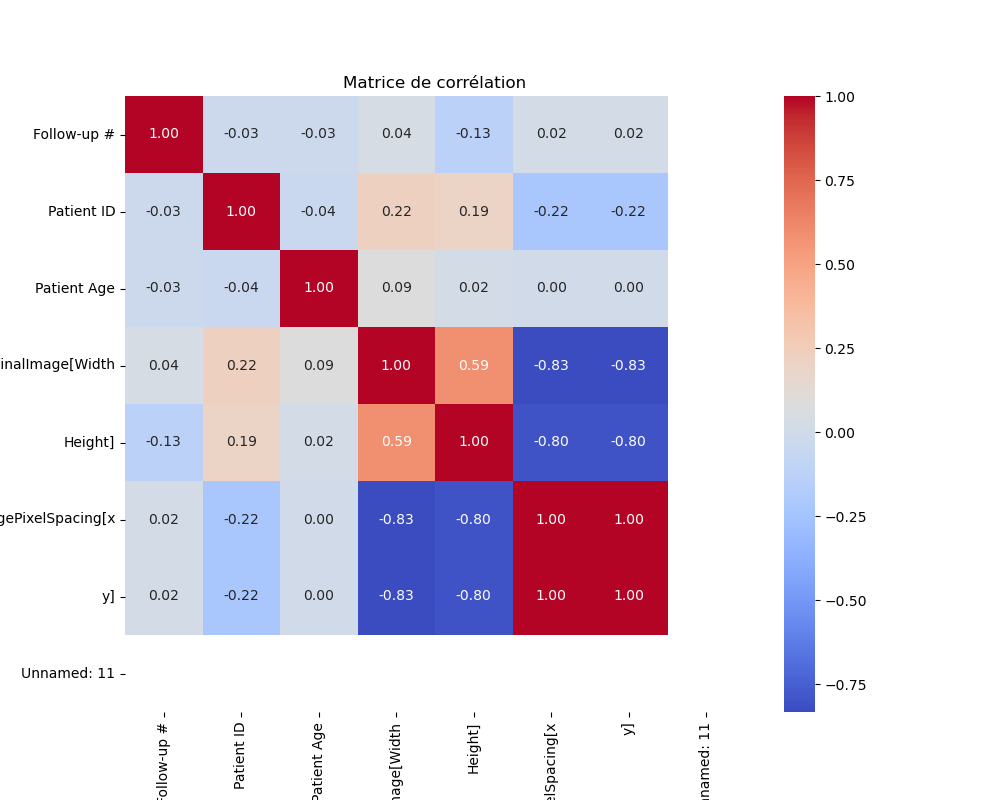

In [233]:
# Sélectionner uniquement les colonnes numériques
numeric_df = data_entry.select_dtypes(include=[float, int])

# Heatmap des corrélations pour les colonnes numériques
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation')
plt.show()

### Data Preprocessing:

In [234]:
#Rename columns for greater clarity 
merged_data = merged_data.rename(columns={
    'Bbox [x': 'bbox_x',
    'y': 'bbox_y',
    'w': 'bbox_w',
    'h]': 'bbox_h'
})
print(merged_data.columns)
# Check for duplicate column names 
print(merged_data.columns[merged_data.columns.duplicated()])

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Finding Label', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')
Index([], dtype='object')


In [235]:
# List of current columns
columns = merged_data.columns.tolist()

# Dictionary to track occurrences of each column name
column_count = {}

# New list to store renamed column names
new_columns = []

for col in columns:
    if col in column_count:
        column_count[col] += 1
        new_columns.append(f"{col}_{column_count[col]}")
    else:
        column_count[col] = 1
        new_columns.append(col)

# Apply new column names to the DataFrame
merged_data.columns = new_columns

In [236]:
print(merged_data.columns)

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Finding Label', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')


##### Handling Missing Values:

In [237]:
# Supprimer la colonne 'OriginalImagePixelSpacing[y]'
merged_data = merged_data.drop(columns=['y]'])

# Renommer 'OriginalImagePixelSpacing[x]' en 'OriginalImagePixelSpacing'
merged_data = merged_data.rename(columns={'OriginalImagePixelSpacing[x': 'OriginalImagePixelSpacing'})

# Afficher les premières lignes pour vérifier
print("DataFrame après suppression et renommage :")
print(merged_data.head())

DataFrame après suppression et renommage :
        Image Index                      Finding Labels  Follow-up #  \
0  00000032_037.png     Cardiomegaly|Edema|Infiltration           37   
1  00000072_000.png                         Atelectasis            0   
2  00000147_001.png                         Atelectasis            1   
3  00000149_006.png                         Atelectasis            6   
4  00000150_002.png  Atelectasis|Infiltration|Pneumonia            2   

   Patient ID  Patient Age Patient Gender View Position  OriginalImage[Width  \
0          32           55              F            AP                 2500   
1          72           67              F            PA                 2450   
2         147           66              F            PA                 2742   
3         149           71              M            AP                 2500   
4         150           55              F            AP                 3056   

   Height]  OriginalImagePixelSpacing  Unna

In [238]:
# Afficher les colonnes 'Unnamed'
unnamed_columns = merged_data.filter(like='Unnamed').columns
print("Colonnes 'Unnamed' trouvées :", unnamed_columns.tolist())

# Supprimer les colonnes 'Unnamed'
merged_data = merged_data.drop(columns=unnamed_columns)

# Afficher les premières lignes pour vérifier
print("\nDataFrame après suppression des colonnes 'Unnamed' :")
print(merged_data.head())

Colonnes 'Unnamed' trouvées : ['Unnamed: 11', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8']

DataFrame après suppression des colonnes 'Unnamed' :
        Image Index                      Finding Labels  Follow-up #  \
0  00000032_037.png     Cardiomegaly|Edema|Infiltration           37   
1  00000072_000.png                         Atelectasis            0   
2  00000147_001.png                         Atelectasis            1   
3  00000149_006.png                         Atelectasis            6   
4  00000150_002.png  Atelectasis|Infiltration|Pneumonia            2   

   Patient ID  Patient Age Patient Gender View Position  OriginalImage[Width  \
0          32           55              F            AP                 2500   
1          72           67              F            PA                 2450   
2         147           66              F            PA                 2742   
3         149           71              M            AP                 2500   
4         150           5

In [239]:
# Supprimer les lignes où 'Finding Label' est 'No Finding'
merged_data = merged_data[merged_data['Finding Labels'] != 'No Finding']

# Réinitialiser l'index (optionnel, mais recommandé après la suppression de lignes)
merged_data = merged_data.reset_index(drop=True)

# Trouver le numéro de colonne de 'Finding Labels'
rows_index = merged_data.shape[0]

# Afficher le numéro de colonne
print(f"Le numéro de colonne de 'Finding Labels' est : {rows_index}")

Le numéro de colonne de 'Finding Labels' est : 984


##### Encoding Labels:

In [240]:
# Encodage binaire de la colonne 'Patient Gender'
merged_data['Patient Gender'] = merged_data['Patient Gender'].map({'M': 1, 'F': 0})

# Encodage binaire de la colonne 'View Position'
merged_data['View Position'] = merged_data['View Position'].map({'AP': 1, 'PA': 0})


In [241]:
# One-hot encoding the 'Finding Labels' column
labels = merged_data['Finding Labels'].str.get_dummies(sep='|')

# Adding the one-hot encoded labels to the dataframe
merged_data = pd.concat([merged_data, labels], axis=1)

# Supprimer les colonnes catégorielles originales (optionnel mais recommandé)
merged_data = merged_data.drop(columns=['Finding Labels'])

# Afficher les premières lignes pour vérifier
print("DataFrame après encodage :")
print(merged_data.head())

DataFrame après encodage :
        Image Index  Follow-up #  Patient ID  Patient Age  Patient Gender  \
0  00000032_037.png           37          32           55               0   
1  00000072_000.png            0          72           67               0   
2  00000147_001.png            1         147           66               0   
3  00000149_006.png            6         149           71               1   
4  00000150_002.png            2         150           55               0   

   View Position  OriginalImage[Width  Height]  OriginalImagePixelSpacing  \
0              1                 2500     2048                      0.168   
1              0                 2450     2839                      0.143   
2              0                 2742     2948                      0.143   
3              1                 2500     2048                      0.168   
4              1                 3056     2544                      0.139   

  Finding Label  ...  Effusion  Emphysema  Fibr

###  Splitting the Data:

In [242]:
# Splitting the data into training and testing sets
train_data, test_data = train_test_split(merged_data, test_size=0.2, random_state=42)

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (787, 28)
Testing data shape: (197, 28)


### Visualizing Images with Bounding Boxes:

Image found in images_006: Data\daataset3\images_006\images\00012636_000.png


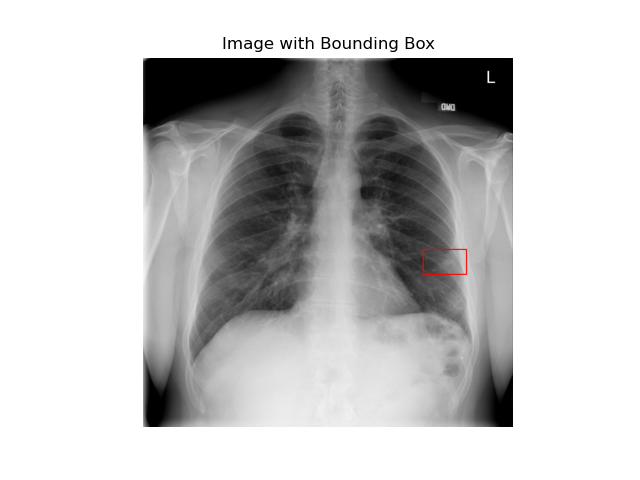

In [ ]:
# Fermer toutes les figures existantes
plt.close('all')

# Function to display an image with its bounding box
def display_image_with_bbox(image_path, bbox):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}. Check the path.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x, y, w, h = bbox
    cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)
    
    # Créer une nouvelle figure explicite
    plt.figure()
    plt.imshow(image)
    plt.title('Image with Bounding Box')
    plt.axis('off')
    plt.show()

# Exemple : Afficher une image avec sa bounding box
sample_image = train_data.iloc[random.randint(0, len(train_data) - 1)]  # Sélectionne une image aléatoire
image_index = sample_image['Image Index']  # Accède à la colonne 'ImageIndex'

# Chemin de base contenant les dossiers image1 à image12
base_path = r"Data\daataset3"

# Liste des dossiers à rechercher (image1 à image12)
folders_to_search = [f"images_00{i}" for i in range(1, 10)] + [f"images_0{i}" for i in range(10, 13)]

# Variable pour suivre si l'image est trouvée
image_found = False

# Rechercher l'image dans chaque dossier
for folder in folders_to_search:
    image_path = os.path.join(base_path, folder, "images", image_index)  # Construit le chemin complet de l'image
    if os.path.exists(image_path):
        print(f"Image found in {folder}: {image_path}")
        bbox = [sample_image['bbox_x'], sample_image['bbox_y'], sample_image['bbox_w'], sample_image['bbox_h']]  # Récupère les coordonnées de la bounding box
        display_image_with_bbox(image_path, bbox)
        image_found = True
        break  # Arrête la recherche une fois l'image trouvée

# Si l'image n'est trouvée dans aucun dossier
if not image_found:
    print(f"Error: Image {image_index} not found in any folder.")